# PDI Accuracy Analysis (GLM/GEE): AIC and R^2 Comparison

This notebook reproduces the functionality of `linreg.py` by:
- loading Experiment 1 data,
- fitting four models (Linear, Quadratic, Cubic, Log),
- comparing models using AIC and weighted R^2,
- plotting fitted curves with 95% confidence intervals.

By default, data are read from `../Data/*.csv` relative to this notebook's location (the `Analysis` directory).


In [ ]:
# Optional: install dependencies if running in a fresh environment
# !pip install pandas numpy matplotlib statsmodels scipy


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from scipy.stats import chi2
import glob
import warnings


In [5]:
class PDIAnalyzer:
    """Analyzes accuracy vs PDI using multiple model fits."""

    def __init__(self, data_path="../Data/*.csv"):
        self.data = self._load_data(data_path)
        self.df_cell = self._prepare_data()
        self.models = {}

    def _load_data(self, path):
        """Load and combine CSV files."""
        files = glob.glob(path)
        if len(files) == 1:
            return pd.read_csv(files[0])

        data_list = []
        for i, file in enumerate(files):
            df = pd.read_csv(file)
            df['source'] = i
            data_list.append(df)
        return pd.concat(data_list, ignore_index=True)

    def _prepare_data(self):
        """Clean and aggregate data."""
        # Filter and transform
        df = (self.data
              .query("Trial_type == 'experiment'")
              [['PART_ID', 'CSI', 'Corr']]
              .rename(columns={'CSI': 'PDI', 'Corr': 'CORR'})
              .assign(
            PDI=lambda x: pd.to_numeric(x['PDI']) * 16.67,
            PART_ID=lambda x: x['PART_ID'].astype('category'),
            CORR=lambda x: x['CORR'].astype(int)
        )
              .query("PDI >= 0"))

        # Aggregate by participant and PDI
        df_cell = (df.groupby(['PART_ID', 'PDI'])
                   .agg(correct_n=('CORR', 'sum'), total_n=('CORR', 'count'))
                   .reset_index())

        # Sanity check
        if (df_cell['total_n'] != 11).any():
            warnings.warn("Some cells don't have 11 trials.")

        # Create predictors
        pdi_mean = df_cell['PDI'].mean()
        log_pdi_mean = np.log1p(df_cell['PDI']).mean()

        return df_cell.assign(
            PDI100=(df_cell['PDI'] - pdi_mean) / 100,
            PDI1002=lambda x: x['PDI100'] ** 2,
            PDI1003=lambda x: x['PDI100'] ** 3,
            lPDIc=np.log1p(df_cell['PDI']) - log_pdi_mean,
            prop_correct=lambda x: x['correct_n'] / x['total_n']
        )

    def fit_models(self):
        """Fit all four models."""
        model_specs = {
            'Linear': ['PDI100'],
            'Quadratic': ['PDI100', 'PDI1002'],
            'Cubic': ['PDI100', 'PDI1002', 'PDI1003'],
            'Log': ['lPDIc']
        }

        for name, predictors in model_specs.items():
            self.models[name] = self._fit_binomial_model(predictors)

        return self.models

    def _fit_binomial_model(self, predictors):
        """Fit binomial GLM with GEE for clustering."""
        try:
            X = sm.add_constant(self.df_cell[predictors])
            model = sm.GEE(
                self.df_cell['prop_correct'], X,
                groups=self.df_cell['PART_ID'],
                family=sm.families.Binomial(),
                cov_struct=sm.cov_struct.Exchangeable()
            )
            return model.fit()
        except:
            # Fallback to regular GLM
            model = sm.GLM(self.df_cell['prop_correct'], X,
                           family=sm.families.Binomial())
            return model.fit()

    def analyze_trends(self):
        """Perform statistical tests and comparisons."""
        if 'Linear' not in self.models:
            raise ValueError("Models must be fitted first.")

        # Linear trend analysis
        lin_model = self.models['Linear']
        b_lin = lin_model.params['PDI100']
        se_lin = lin_model.bse['PDI100']
        z_lin = b_lin / se_lin
        p_lin = 2 * (1 - stats.norm.cdf(abs(z_lin)))

        print("=== Linear Trend Test ===")
        print(f"Slope per +100ms: b={b_lin:.4f}, SE={se_lin:.4f}, z={z_lin:.2f}, p={p_lin:.4g}")
        print(
            f"Odds ratio: {np.exp(b_lin):.3f} [{np.exp(b_lin - 1.96 * se_lin):.3f}, {np.exp(b_lin + 1.96 * se_lin):.3f}]")

        # Polynomial term tests
        self._test_polynomial_terms()

        # AIC comparison
        self._compare_models()

    def _test_polynomial_terms(self):
        """Test significance of higher-order terms."""
        print("\n=== Polynomial Terms ===")

        for model_name, param in [('Quadratic', 'PDI1002'), ('Cubic', 'PDI1003')]:
            if model_name in self.models and param in self.models[model_name].params:
                model = self.models[model_name]
                b = model.params[param]
                se = model.bse[param]
                z = b / se
                p = 2 * (1 - stats.norm.cdf(abs(z)))
                print(f"{param}: b={b:.4f}, SE={se:.4f}, z={z:.2f}, p={p:.4g}")

    def _weighted_r2(self, y_true, y_pred, weights=None):
        """Compute weighted R^2 (coefficient of determination) on probabilities.

        Parameters
        - y_true: array-like of true proportions
        - y_pred: array-like of predicted proportions
        - weights: array-like of weights (e.g., total_n per cell); if None, equal weights are used
        """
        y_true = np.asarray(y_true, dtype=float)
        y_pred = np.asarray(y_pred, dtype=float)
        if weights is None:
            weights = np.ones_like(y_true, dtype=float)
        else:
            weights = np.asarray(weights, dtype=float)
        m = np.isfinite(y_true) & np.isfinite(y_pred) & np.isfinite(weights)
        if not np.any(m):
            return np.nan
        y_true = y_true[m]
        y_pred = y_pred[m]
        weights = weights[m]
        w_sum = weights.sum()
        if w_sum <= 0:
            return np.nan
        y_bar = np.sum(weights * y_true) / w_sum
        ss_tot = np.sum(weights * (y_true - y_bar) ** 2)
        ss_res = np.sum(weights * (y_true - y_pred) ** 2)
        if ss_tot <= 0:
            return np.nan
        return 1.0 - ss_res / ss_tot

    def _compare_models(self):
        """Compare models using AIC and weighted R^2 (on fitted probabilities)."""
        print("\n=== Model Comparison (AIC, R^2) ===")

        # Prepare true values and weights
        y_true = self.df_cell['prop_correct'].values
        weights = self.df_cell['total_n'].values if 'total_n' in self.df_cell.columns else np.ones_like(y_true)

        # Mapping of predictors per model name
        predictor_map = {
            'Linear': ['PDI100'],
            'Quadratic': ['PDI100', 'PDI1002'],
            'Cubic': ['PDI100', 'PDI1002', 'PDI1003'],
            'Log': ['lPDIc']
        }

        rows = []
        for name, model in self.models.items():
            # Predictions and R^2
            r2 = np.nan
            try:
                cols = predictor_map.get(name, [])
                X = sm.add_constant(self.df_cell[cols])
                y_pred = np.asarray(model.predict(X), dtype=float)
                r2 = self._weighted_r2(y_true, y_pred, weights)
            except Exception:
                r2 = np.nan

            # AIC if available
            aic = getattr(model, 'aic', np.nan)

            rows.append({'Model': name, 'AIC': aic, 'R2': r2})

        comp = pd.DataFrame(rows)

        # Sort by AIC if any available, otherwise by R^2 descending
        if np.isfinite(comp['AIC']).any():
            comp = comp.sort_values('AIC')
            comp['ΔAIC'] = comp['AIC'] - np.nanmin(comp['AIC'])
        else:
            comp = comp.sort_values('R2', ascending=False)

        # Print table
        for _, row in comp.iterrows():
            aic_str = f"{row['AIC']:.1f}" if np.isfinite(row['AIC']) else "NA"
            daic_str = f", ΔAIC={row['ΔAIC']:.1f}" if 'ΔAIC' in comp.columns and np.isfinite(row.get('ΔAIC', np.nan)) else ""
            r2_str = f"{row['R2']:.3f}" if np.isfinite(row['R2']) else "NA"
            print(f"{row['Model']:<10} AIC={aic_str}{daic_str}, R^2={r2_str}")

        # Best model message
        if 'ΔAIC' in comp.columns:
            print(f"\nBest model (AIC): {comp.iloc[0]['Model']}")
        else:
            print(f"\nBest model (R^2): {comp.iloc[0]['Model']}")

    def plot_fits(self, figsize=(10, 6)):
        """Plot all model fits with confidence intervals."""
        if not self.models:
            raise ValueError("Models must be fitted first.")

        # Create prediction grid
        pdi_range = np.linspace(self.df_cell['PDI'].min(), self.df_cell['PDI'].max(), 200)
        grid = self._create_prediction_grid(pdi_range)

        # Plot setup
        fig, ax = plt.subplots(figsize=figsize)
        colors = {'Linear': '#2c7fb8', 'Quadratic': '#f03b20',
                  'Cubic': '#6a3d9a', 'Log': '#33a02c'}

        # Plot each model
        for name, model in self.models.items():
            predictions = self._predict_with_ci(model, grid, name)

            ax.fill_between(pdi_range, predictions['lo'], predictions['hi'],
                            alpha=0.15, color=colors[name])
            ax.plot(pdi_range, predictions['fit'],
                    color=colors[name], linewidth=2, label=name)

        ax.set_xlabel('PDI (ms)')
        ax.set_ylabel('Accuracy')
        ax.set_title('Model Fits: Accuracy vs PDI (95% CI)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def _create_prediction_grid(self, pdi_range):
        """Create prediction grid with all predictors."""
        pdi_mean = self.df_cell['PDI'].mean()
        log_pdi_mean = np.log1p(self.df_cell['PDI']).mean()

        pdi100 = (pdi_range - pdi_mean) / 100
        return pd.DataFrame({
            'PDI': pdi_range,
            'PDI100': pdi100,
            'PDI1002': pdi100 ** 2,
            'PDI1003': pdi100 ** 3,
            'lPDIc': np.log1p(pdi_range) - log_pdi_mean
        })

    def _predict_with_ci(self, model, grid, model_name):
        """Make predictions with confidence intervals."""
        predictor_map = {
            'Linear': ['PDI100'],
            'Quadratic': ['PDI100', 'PDI1002'],
            'Cubic': ['PDI100', 'PDI1002', 'PDI1003'],
            'Log': ['lPDIc']
        }

        try:
            X_pred = sm.add_constant(grid[predictor_map[model_name]])
            pred = model.predict(X_pred)
            se_pred = np.sqrt(np.diag(X_pred @ model.cov_params() @ X_pred.T))

            # Convert to probability scale
            fit = 1 / (1 + np.exp(-pred))
            lo = 1 / (1 + np.exp(-(pred - 1.96 * se_pred)))
            hi = 1 / (1 + np.exp(-(pred + 1.96 * se_pred)))

            return {'fit': fit, 'lo': lo, 'hi': hi}
        except:
            # Fallback
            n = len(grid)
            return {'fit': np.full(n, 0.5), 'lo': np.full(n, 0.4), 'hi': np.full(n, 0.6)}


/tmp/ipykernel_203851/2588775290.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cell = (df.groupby(['PART_ID', 'PDI'])
/tmp/ipykernel_203851/2588775290.py:43: UserWarning: Some cells don't have 11 trials.
  warnings.warn("Some cells don't have 11 trials.")


=== Linear Trend Test ===
Slope per +100ms: b=0.0316, SE=0.0036, z=8.66, p=0
Odds ratio: 1.032 [1.025, 1.039]

=== Polynomial Terms ===
PDI1002: b=-0.0035, SE=0.0013, z=-2.65, p=0.007945
PDI1003: b=0.0008, SE=0.0007, z=1.08, p=0.2784

=== Model Comparison (AIC, R^2) ===
Log        AIC=6048.0, ΔAIC=0.0, R^2=0.005
Linear     AIC=6048.5, ΔAIC=0.5, R^2=0.005
Quadratic  AIC=6050.1, ΔAIC=2.1, R^2=0.005
Cubic      AIC=6052.0, ΔAIC=4.0, R^2=0.005

Best model (AIC): Log


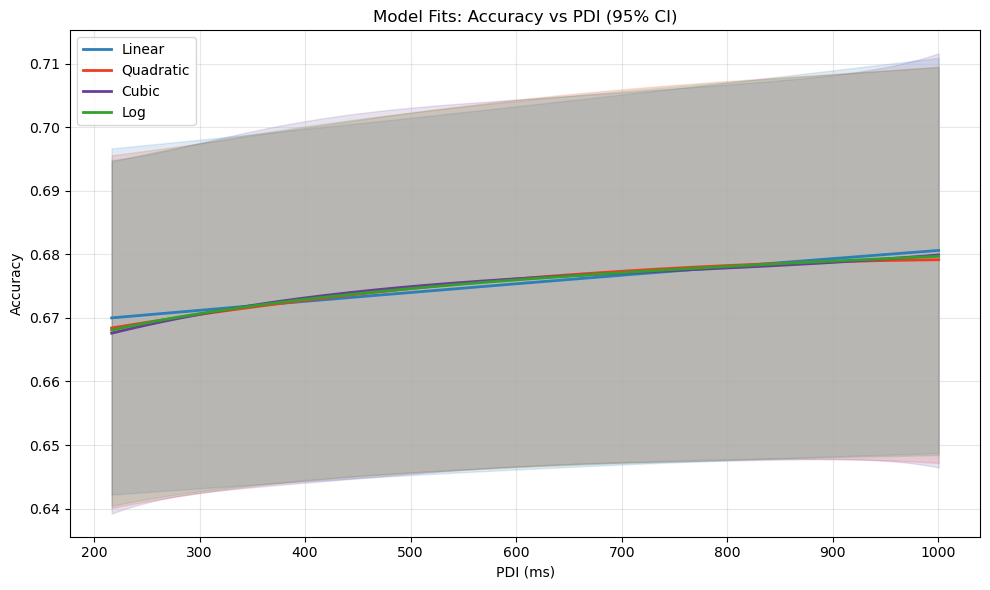

In [6]:
# Run the analysis
analyzer = PDIAnalyzer()
_ = analyzer.fit_models()
analyzer.analyze_trends()
analyzer.plot_fits()



=== Residual analysis for best model: Log (AIC=6048.0) ===
Pearson overdispersion: X^2=15811.71, df=7054, dispersion=2.242, p=0
Hosmer–Lemeshow: X^2=1.39, df=8, p=0.9944


/tmp/ipykernel_203851/1375056391.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _grp = _df_g.groupby('group', observed=False).apply(lambda d: pd.Series({


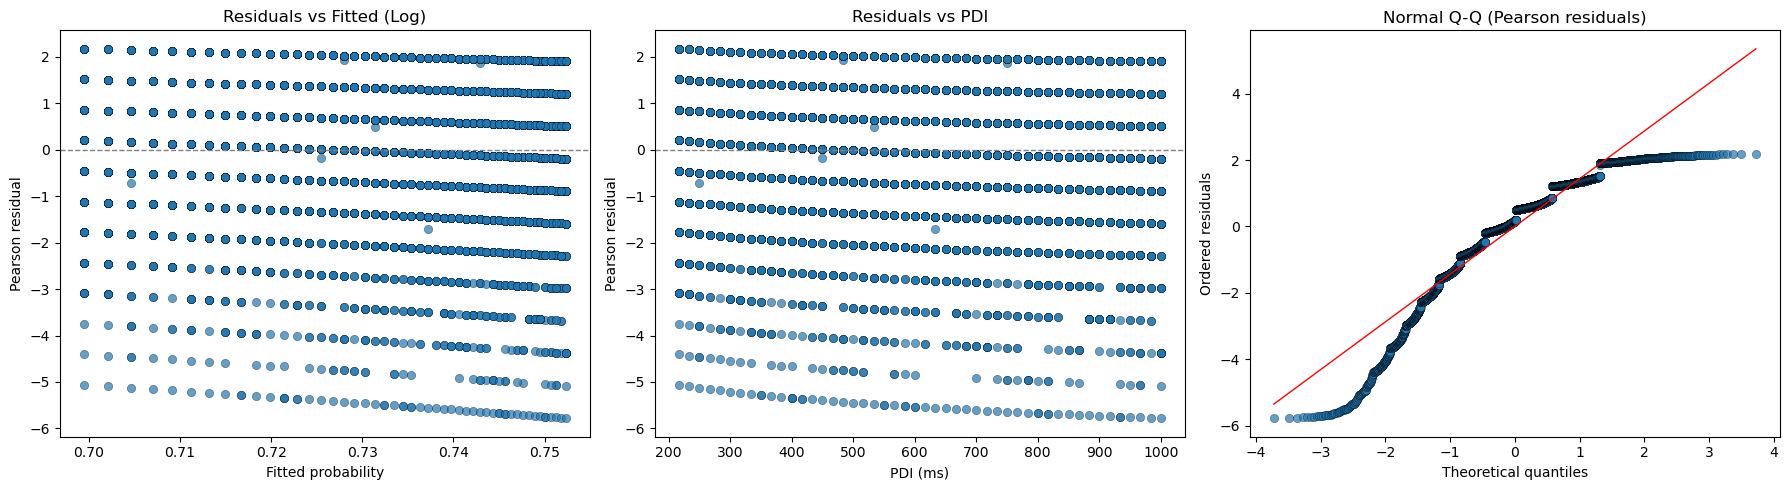

Points with |Pearson residual| > 3: 322


In [7]:
# Residual diagnostics for best model (plots + formal tests)
# This section selects the best model (by AIC if available, else by weighted R^2)
# and performs residual analyses with plots and goodness-of-fit tests.

# Map predictors used by each model name
_predictor_map = {
    'Linear': ['PDI100'],
    'Quadratic': ['PDI100', 'PDI1002'],
    'Cubic': ['PDI100', 'PDI1002', 'PDI1003'],
    'Log': ['lPDIc']
}

# Helper: weighted R^2 on probabilities
_def_eps = 1e-9

def _weighted_r2_probs(y_true, y_pred, weights):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    w = np.asarray(weights, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred) & np.isfinite(w)
    if not np.any(m):
        return np.nan
    y_true = y_true[m]
    y_pred = y_pred[m]
    w = w[m]
    wsum = w.sum()
    if wsum <= 0:
        return np.nan
    ybar = np.sum(w * y_true) / wsum
    ss_tot = np.sum(w * (y_true - ybar) ** 2)
    ss_res = np.sum(w * (y_true - y_pred) ** 2)
    if ss_tot <= 0:
        return np.nan
    return 1.0 - ss_res / ss_tot

# Select best model
_rows = []
_y_true = analyzer.df_cell['prop_correct'].values
_weights = analyzer.df_cell['total_n'].values if 'total_n' in analyzer.df_cell.columns else np.ones_like(_y_true)
for _name, _model in analyzer.models.items():
    try:
        _cols = _predictor_map.get(_name, [])
        _X = sm.add_constant(analyzer.df_cell[_cols])
        _yp = np.asarray(_model.predict(_X), dtype=float)
        _r2 = _weighted_r2_probs(_y_true, _yp, _weights)
    except Exception:
        _r2 = np.nan
        _cols = _predictor_map.get(_name, [])
    _aic = getattr(_model, 'aic', np.nan)
    _rows.append({'Model': _name, 'AIC': _aic, 'R2': _r2, 'Predictors': _cols, 'ModelObj': _model})

_comp = pd.DataFrame(_rows)
if np.isfinite(_comp['AIC']).any():
    _comp = _comp.sort_values('AIC')
    _best = _comp.iloc[0]
    _best_crit = f"AIC={_best['AIC']:.1f}"
else:
    _comp = _comp.sort_values('R2', ascending=False)
    _best = _comp.iloc[0]
    _best_crit = f"R^2={_best['R2']:.3f}"

print(f"\n=== Residual analysis for best model: {_best['Model']} ({_best_crit}) ===")

# Data for diagnostics
_best_name = _best['Model']
_best_model = _best['ModelObj']
_best_cols = list(_best['Predictors'])
_Xb = sm.add_constant(analyzer.df_cell[_best_cols])
_mu = np.asarray(_best_model.predict(_Xb), dtype=float)
_n = analyzer.df_cell['total_n'].to_numpy()
_k = analyzer.df_cell['correct_n'].to_numpy()
_y = _k / _n

# Clip probabilities to avoid 0/1 in logs/variance
_mu = np.clip(_mu, _def_eps, 1 - _def_eps)
_yc = np.clip(_y, _def_eps, 1 - ( _def_eps))

# Pearson and deviance residuals (aggregated binomial)
_pearson = (_k - _n * _mu) / np.sqrt(_n * _mu * (1 - _mu))
_dev_terms = 2 * _n * (_yc * np.log(_yc / _mu) + (1 - _yc) * np.log((1 - _yc) / (1 - _mu)))
_deviance = np.sign(_y - _mu) * np.sqrt(np.maximum(_dev_terms, 0.0))

# Formal tests
_p = len(_best_cols) + 1  # intercept + predictors
_df = max(len(_y) - _p, 1)
_pearson_chi2 = float(np.sum(((_k - _n * _mu) ** 2) / (_n * _mu * (1 - _mu))))
_dispersion = _pearson_chi2 / _df
_p_over = stats.chi2.sf(_pearson_chi2, _df)
print(f"Pearson overdispersion: X^2={_pearson_chi2:.2f}, df={_df}, dispersion={_dispersion:.3f}, p={_p_over:.4g}")

# Hosmer–Lemeshow GOF (group by predicted probability deciles)
_G = min(10, len(_y))
try:
    _groups = pd.qcut(pd.Series(_mu), q=_G, duplicates='drop')
except Exception:
    _groups = pd.cut(pd.Series(_mu), bins=_G)
_df_g = pd.DataFrame({'mu': _mu, 'n': _n, 'k': _k, 'group': _groups})
_grp = _df_g.groupby('group', observed=False).apply(lambda d: pd.Series({
    'O': d['k'].sum(),
    'E': float(np.sum(d['n'] * d['mu'])),
    'V': float(np.sum(d['n'] * d['mu'] * (1 - d['mu']))),
    'n_g': d['n'].sum()
})).reset_index(drop=True)
# Drop any groups with zero variance to avoid division by zero
_grp = _grp[_grp['V'] > 0]
_G_eff = len(_grp)
if _G_eff >= 3:
    _hl_chi2 = float(np.sum((_grp['O'] - _grp['E']) ** 2 / _grp['V']))
    _hl_df = _G_eff - 2
    _hl_p = stats.chi2.sf(_hl_chi2, _hl_df)
    print(f"Hosmer–Lemeshow: X^2={_hl_chi2:.2f}, df={_hl_df}, p={_hl_p:.4g}")
else:
    print("Hosmer–Lemeshow: not enough groups to compute the test.")

# Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Residuals vs Fitted
axes[0].scatter(_mu, _pearson, alpha=0.7, edgecolor='k', linewidth=0.3)
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[0].set_xlabel('Fitted probability')
axes[0].set_ylabel('Pearson residual')
axes[0].set_title(f'Residuals vs Fitted ({_best_name})')

# Residuals vs PDI
axes[1].scatter(analyzer.df_cell['PDI'], _pearson, alpha=0.7, edgecolor='k', linewidth=0.3)
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1].set_xlabel('PDI (ms)')
axes[1].set_ylabel('Pearson residual')
axes[1].set_title('Residuals vs PDI')

# Normal Q-Q plot for Pearson residuals
qq = stats.probplot(_pearson, dist='norm')
osm = qq[0][0]
osr = qq[0][1]
slope = qq[1][0]
intercept = qq[1][1]
axes[2].scatter(osm, osr, alpha=0.7, edgecolor='k', linewidth=0.3)
line_x = np.linspace(np.min(osm), np.max(osm), 100)
axes[2].plot(line_x, slope * line_x + intercept, color='red', linewidth=1)
axes[2].set_title('Normal Q-Q (Pearson residuals)')
axes[2].set_xlabel('Theoretical quantiles')
axes[2].set_ylabel('Ordered residuals')

plt.tight_layout()
plt.show()

# Outlier count
_out_n = int(np.sum(np.abs(_pearson) > 3))
if _out_n > 0:
    print(f"Points with |Pearson residual| > 3: {_out_n}")
else:
    print("No large Pearson residual outliers (>|3|)")
